In [16]:
import pandas as pd
import datasets
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.nn.parallel import DataParallel
import numpy as np

In [17]:
from io import BytesIO
import urllib
from urllib.request import urlopen
from zipfile import ZipFile
import os
zipurl = "https://gohkust.sharepoint.com/teams/DEEPART/_layouts/15/download.aspx?SourceUrl=%2Fteams%2FDEEPART%2FShared%20Documents%2FGeneral%2FDataset%2Ftoy%5Fdataset%2Ezip"
hdr = {'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8'}
req = urllib.request.Request(url=zipurl, header=hdr)
if not os.path.isdir('./images/'):
    with urlopen(req) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            zfile.extractall('./images/')


In [18]:
train_data = pd.read_csv('./described_dataset_label.csv',sep='\t',encoding='latin-1', index_col=[0])
print(f'coumns:{[x for x in train_data.columns]}')

coumns:['ID', 'FILE', 'AUTHOR', 'BORN-DIED', 'TITLE', 'DATE', 'TECHNIQUE', 'LOCATION', 'FORM', 'TYPE', 'SCHOOL', 'TIMELINE', 'URL']


In [19]:
train_data.describe()

,ID
count,153.000000
mean,77.000000
std,44.311398
min,1.000000
25%,39.000000
50%,77.000000
75%,115.000000
max,153.000000


In [20]:
train_data.head()

,ID,FILE,AUTHOR,BORN-DIED,TITLE,DATE,TECHNIQUE,LOCATION,FORM,TYPE,SCHOOL,TIMELINE,URL
0,1,./images/1.jpg,"AACHEN, Hans von","(b. 1552, KÃ¶ln, d. 1615, Praha)",Allegory,1598,"Oil on copper, 56 x 47 cm","Alte Pinakothek, Munich",painting,mythological,German,1601-1650,"The painting, displaying the characteristic Ma..."
1,2,./images/2.jpg,"AACHEN, Hans von","(b. 1552, KÃ¶ln, d. 1615, Praha)","Bacchus, Ceres and Cupid",-,"Oil on canvas, 163 x 113 cm","Kunsthistorisches Museum, Vienna",painting,mythological,German,1601-1650,The representation of this group is related to...
2,3,./images/3.jpg,"AACHEN, Hans von","(b. 1552, KÃ¶ln, d. 1615, Praha)",Joking Couple,-,"Copperplate, 25 x 20 cm","Kunsthistorisches Museum, Vienna",painting,genre,German,1601-1650,At the end of the 16th century the court of Em...
3,4,./images/4.jpg,"AACHEN, Hans von","(b. 1552, KÃ¶ln, d. 1615, Praha)",Portrait of Emperor Rudolf II,1590s,"Oil on canvas, 60 x 48 cm","Kunsthistorisches Museum, Vienna",painting,portrait,German,1601-1650,Rudolf II (1552-1612) was the son of the Holy ...
4,5,./images/5.jpg,"AACHEN, Hans von","(b. 1552, KÃ¶ln, d. 1615, Praha)",Self-Portrait with a Glass of Wine,c. 1596,"Oil on canvas, 53 x 44 cm",Private collection,painting,portrait,German,1601-1650,Hans von Aachen was an artist who fully embrac...


In [21]:
features = ['FILE','AUTHOR','TECHNIQUE','URL']
train_data = train_data[features]
train_data = train_data[:500]
train_data['TECHNIQUE'] = train_data['TECHNIQUE'].str.split(',').str[0]
train_data['TECHNIQUE'] = train_data['TECHNIQUE'].str.split(':').str[0]
train_data.head()

,FILE,AUTHOR,TECHNIQUE,URL
0,./images/1.jpg,"AACHEN, Hans von",Oil on copper,"The painting, displaying the characteristic Ma..."
1,./images/2.jpg,"AACHEN, Hans von",Oil on canvas,The representation of this group is related to...
2,./images/3.jpg,"AACHEN, Hans von",Copperplate,At the end of the 16th century the court of Em...
3,./images/4.jpg,"AACHEN, Hans von",Oil on canvas,Rudolf II (1552-1612) was the son of the Holy ...
4,./images/5.jpg,"AACHEN, Hans von",Oil on canvas,Hans von Aachen was an artist who fully embrac...


In [22]:
train_data.dropna()
train_data = train_data[train_data['URL'] != 0]

In [23]:
train_data = train_data.rename(columns={'FILE':'image','AUTHOR':'author', 'TECHNIQUE':'style','URL':'description'})

In [24]:
labels_auth = train_data['author'].unique()
label2id_auth, id2label_auth = dict(), dict()
for i, label in enumerate(labels_auth):
    label2id_auth[label]=i
    id2label_auth[i]=label

In [25]:
labels_sty = train_data['style'].unique()
label2id_sty, id2label_sty = dict(), dict()
for i, label in enumerate(labels_sty):
    label2id_sty[label]=i
    id2label_sty[i]=label

In [26]:
train_data['author'] = train_data['author'].map(label2id_auth)
train_data['style'] = train_data['style'].map(label2id_sty)
train_data.columns

Index(['image', 'author', 'style', 'description'], dtype='object')

In [27]:
train_dataset = datasets.Dataset.from_dict(train_data).cast_column('image',datasets.Image())
train_dataset_git = datasets.Dataset.from_dict(train_data[['image','description']]).cast_column('image',datasets.Image())
train_dataset_vit_auth = datasets.Dataset.from_dict(train_data[['image','author']]).cast_column('image',datasets.Image())
train_dataset_vit_style = datasets.Dataset.from_dict(train_data[['image','style']]).cast_column('image',datasets.Image())
print(train_dataset)

AttributeError: module 'datasets' has no attribute 'Dataset'

In [44]:
sample = train_dataset[26]

image = sample['image']
height,width = image.size
display(image.resize((int(0.3*height),int(0.3*width))))
caption = sample['description']
author = sample['author']
technique = sample['style']
print(f'Description: {caption}')
print(f'Author: {author}')
print(f'Technique: {technique}')

NameError: name 'train_dataset' is not defined

In [45]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["description"], padding="max_length", return_tensors="pt", truncation=True)
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

ModuleNotFoundError: No module named 'torch.utils'

In [ ]:
from torch.utils.data import Dataset

class ImageClassificationDataset(Dataset):
    
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["label"], padding="max_length", return_tensors="pt", truncation=True)
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

In [ ]:
from transformers import AutoProcessor

processor_clas = AutoProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
processor_capt = AutoProcessor.from_pretrained("microsoft/git-base")

2023-08-08 14:49:41.467425: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=processor_clas.image_mean, std=processor_clas.image_std)

size = (

    processor_clas.size["shortest_edge"]

    if "shortest_edge" in processor_clas.size

    else (processor_clas.size["height"], processor_clas.size["width"])

)

_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [ ]:
def transforms(examples):
    examples['pixel_values'] = [_transforms(img.convert('RGB'))for img in examples['image']]
    del examples['image']
    return examples

In [ ]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

checkpoint= 'google/vit-base-patch16-224-in21k'

model_clas_auth = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels = len(labels_auth),
    id2label = id2label_auth,
    label2id = label2id_auth
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_clas_sty = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels = len(labels_sty),
    id2label = id2label_sty,
    label2id = label2id_sty
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset_vit_auth = train_dataset_vit_auth.rename_column('author','label')
train_dataset_vit_style = train_dataset_vit_style.rename_column('style','label')
train_capt = ImageCaptioningDataset(train_dataset_git,processor_capt)
# train_dataset_vit_auth = ImageClassificationDataset(train_dataset_vit_auth,processor_clas)
# train_dataset_vit_style = ImageClassificationDataset(train_dataset_vit_style,processor_clas)
train_sty = train_dataset_vit_style.with_transform(transforms)
train_auth = train_dataset_vit_auth.with_transform(transforms)

In [ ]:
from torch.utils.data import DataLoader
train_dataloader_vit_sty = DataLoader(train_sty,shuffle=True,batch_size=2)
train_dataloader_vit_auth = DataLoader(train_auth, shuffle=True, batch_size=2)
train_dataloader_git = DataLoader(train_capt,shuffle=True,batch_size=2)

In [ ]:
from transformers import AutoModelForCausalLM

model_capt = AutoModelForCausalLM.from_pretrained('microsoft/git-base')

In [ ]:
batch = next(iter(train_dataloader_git))
for k,v in batch.items():
    print(k,v.shape)

input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])
pixel_values torch.Size([2, 3, 224, 224])


In [ ]:
outputs = model_capt(input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                pixel_values=batch['pixel_values'],
                labels=batch['input_ids'])

outputs.loss

tensor(8.2316, grad_fn=<NllLossBackward0>)

In [ ]:
vit_model_auth = model_clas_auth #nn.DataParallel(model_clas_auth)
vit_model_sty = model_clas_sty #nn.DataParallel(model_clas_sty)

In [ ]:
vit_optimizer_auth = torch.optim.AdamW(vit_model_auth.parameters(), lr=1e-5)
vit_optimizer_sty = torch.optim.AdamW(vit_model_sty.parameters(), lr=1e-5)
git_optimizer = torch.optim.AdamW(model_capt.parameters(),lr=5e-5)
vit_criterion_auth = nn.CrossEntropyLoss()
vit_criterion_sty = nn.CrossEntropyLoss()
git_criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs_class = 50
num_epochs_capt = 10

In [ ]:
device = 'cpu'
with tqdm(total=num_epochs_class) as pbar_epoch:
    for epoch in range(num_epochs_class):
        #Train Loop ViT Style

        vit_model_sty.train()
        with tqdm(total=len(train_dataloader_vit_sty)) as pbar_vit:
            for idx, batch in enumerate(train_dataloader_vit_sty):
                labels = batch.pop('label').to(device)
                pixel_values=batch.pop('pixel_values').to(device)

                outputs = vit_model_sty(
                                pixel_values=pixel_values,
                                labels = labels)
                loss = outputs.loss

                loss.backward()
                pbar_vit.set_description(f'Loss sty: {loss.item()}')

                vit_optimizer_sty.step()
                vit_optimizer_sty.zero_grad()
                pbar_vit.update()

        #Train Loop ViT Author

        vit_model_auth.train()
        with tqdm(total=len(train_dataloader_vit_auth)) as pbar_vit:
            for idx, batch in enumerate(train_dataloader_vit_auth):
                labels = batch.pop('label').to(device)
                pixel_values=batch.pop('pixel_values').to(device)

                outputs = vit_model_auth(
                                pixel_values=pixel_values,
                                labels = labels)
                loss = outputs.loss
                
                pbar_vit.set_description(f'Loss auth: {loss.item()}')

                loss.backward()

                vit_optimizer_auth.step()
                vit_optimizer_auth.zero_grad()
                pbar_vit.update()
        pbar_epoch.update()

100%|██████████| 50/50 [3:29:52<00:00, 251.86s/it]


In [ ]:
device = 'cpu'
with tqdm(total=num_epochs_capt) as pbar_epoch:
    for epoch in range(num_epochs_capt):
        pbar_epoch.set_description(f'Epoch N°: {epoch}')
        #Train Loop GiT
        with tqdm(total=len(train_dataloader_git)) as pbar_git:
            for idx, batch in enumerate(train_dataloader_git):
                pbar_git.set_description(f'Loss: {loss.item()}')
                input_ids = batch.pop('input_ids').to(device)
                pixel_values=batch.pop('pixel_values').to(device)

                outputs = model_capt(input_ids=input_ids,
                                pixel_values=pixel_values,
                                labels = input_ids)
                loss = outputs.loss

                loss.backward()

                git_optimizer.step()
                git_optimizer.zero_grad()
                pbar_git.update()
        pbar_epoch.update()

Epoch N°: 9: 100%|██████████| 10/10 [1:24:31<00:00, 507.11s/it]


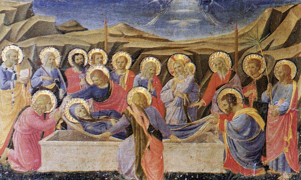

Author: ABILDGAARD, Nicolai
Style:  Oil on canvas
Description: The subject is taken from the Songs of Ossian.


In [ ]:
sample = train_dataset[26]
image = sample['image']
height,width = image.size
display(image.resize((int(0.3*height),int(0.3*width))))
author = sample['author']
style = sample['style']
desc = sample['description']
print(f'Author: {id2label_auth[author]}')
print(f'Style:  {id2label_sty[style]}')
print(f'Description: {desc}')

In [ ]:
torch.save(model_capt.state_dict(), './model_checkpoints/model_capt.pt')
torch.save(model_clas_auth.state_dict(), './model_checkpoints/model_clas_auth.pt')
torch.save(model_clas_sty.state_dict(),'./model_checkpoints/model_clas_sty.pt')

In [ ]:
from transformers import AutoImageProcessor

device = 'cpu' #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

image_processor = AutoImageProcessor.from_pretrained(checkpoint)

inputs = image_processor(image, return_tensors="pt").to(device)

with torch.no_grad():
    logits_auth = model_clas_auth(**inputs).logits

In [ ]:
from transformers import AutoImageProcessor

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

image_processor = AutoImageProcessor.from_pretrained(checkpoint)

inputs = image_processor(image, return_tensors="pt").to(device)

with torch.no_grad():
    logits_sty = model_clas_sty(**inputs).logits

In [ ]:
device = 'cpu'
inputs = processor_capt(images = image, return_tensors='pt').to(device)
pixel_values = inputs.pixel_values

generated_ids = model_capt.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor_capt.batch_decode(generated_ids,skip_special_tokens=True)[0]
print(generated_caption)

the crucifixion scene is located on the altar wall. the grouping and the gestures of the figures are characterized by a particularly high level of sophistication. in the distinct contrast between the serene pose and inward - focused expression of


In [ ]:
predicted_label_auth = logits_auth.argmax(-1).item()
predicted_label_sty = logits_sty.argmax(-1).item()
print(model_clas_auth.config.id2label[predicted_label_auth])
print(model_clas_sty.config.id2label[predicted_label_sty])

ABILDGAARD, Nicolai
Oil on canvas


Put Everything Together

In [ ]:
""" from transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')
predicted_label_auth = model_clas_auth.config.id2label[predicted_label_auth]
predicted_label_sty = model_clas_sty.config.id2label[predicted_label_sty]
text=predicted_label_auth+' '+predicted_label_sty + ' ' + generated_caption
encoded_input = tokenizer(text, return_tensors='pt').to(device)
# output = model(**encoded_input)
generated_ids = model.generate(input_ids = encoded_input.input_ids, attention_mask=encoded_input.attention_mask, max_length=500)
generated_caption = tokenizer.batch_decode(generated_ids,skip_special_tokens=True)[0]
print(generated_caption) """

" from transformers import GPT2Tokenizer, GPT2LMHeadModel\n\ntokenizer = GPT2Tokenizer.from_pretrained('gpt2')\nmodel = GPT2LMHeadModel.from_pretrained('gpt2')\npredicted_label_auth = model_clas_auth.config.id2label[predicted_label_auth]\npredicted_label_sty = model_clas_sty.config.id2label[predicted_label_sty]\ntext=predicted_label_auth+' '+predicted_label_sty + ' ' + generated_caption\nencoded_input = tokenizer(text, return_tensors='pt').to(device)\n# output = model(**encoded_input)\ngenerated_ids = model.generate(input_ids = encoded_input.input_ids, attention_mask=encoded_input.attention_mask, max_length=500)\ngenerated_caption = tokenizer.batch_decode(generated_ids,skip_special_tokens=True)[0]\nprint(generated_caption) "

In [ ]:
predicted_label_auth = model_clas_auth.config.id2label[predicted_label_auth]
predicted_label_sty = model_clas_sty.config.id2label[predicted_label_sty]
text=predicted_label_auth+' '+predicted_label_sty + ' ' + generated_caption

In [ ]:
import torch
from transformers import LlamaModel, LlamaTokenizer

def generate_text(strings, model_name='Llama-2-7b', max_length=100, temperature=1.0, top_k=50):
    # Load pre-trained GPT-2 model and tokenizer
    tokenizer = LlamaTokenizer.from_pretrained(model_name)
    # Add a new padding token to the tokenizer
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

    model = LlamaModel.from_pretrained(model_name)

    # Set the model to evaluation mode (no training)
    model.eval()

    # Tokenize the input strings and convert them to tensors
    inputs = tokenizer(strings, return_tensors='pt', padding=True, truncation=True)

    # Generate text based on the input strings
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_length=max_length,
            temperature=temperature,
            top_k=top_k,
            pad_token_id=tokenizer.eos_token_id
        )

    # Decode the generated tokens back to text
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text

generate_text(text)

NameError: name 'text' is not defined